# Neural Networks Project - Multi-ConDoS

#### Andrea Gervasio, matricola number: 1883259

Existing self-supervised medical image segmentation usually encounters the domain shift problem and/or the multimodality problem. To tackle these problems, the authors of the [paper](https://ieeexplore.ieee.org/document/10167829) *Multi-ConDoS: Multimodal Contrastive Domain Sharing Generative Adversarial Networks for Self-Supervised Medical Image Segmentation* propose multimodal contrastive domain sharing (Multi-ConDoS) generative adversarial networks. \\
The main idea is to fuse CycleGAN and the classic paired image translation model, Pix2Pix, to achieve better domain translation capability. The domain
sharing generative adversarial networks (DSGANs) also uses some shared layers to learn not only domain-specific but also domain-sharing information.

This notebook aims to reimplement this model using the PyTorch Lightning framework.

*Note: this notebook has been tested on Google Colab using a free subscription. Make sure that the runtime is set on T4 GPU before running. \\
The user is not required to do anything, the code will handle the installation of the necessary libraries and the downloads of the data. If the user is interested in logging the training results on the Weights and Biases platform, they should look for the definition of the `log_wandb` parameter in Section 0.*

# 0. Installing and importing necessary libraries and data

In [1]:
!pip install torchvision pytorch-lightning wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.5 MB/s eta 0:00:00


In [2]:
import os
import math
import wandb
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

In [3]:
if not os.path.exists("/content/NNDataset.zip"):
  !gdown --fuzzy https://drive.google.com/file/d/1TmRMMZMuZWjT3_6wjbM5xJ5RXiD474hp/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1TmRMMZMuZWjT3_6wjbM5xJ5RXiD474hp
To: /content/NNDataset.zip
100% 12.4M/12.4M [00:00<00:00, 25.3MB/s]


Setting the random seed for reproducibility.

In [4]:
RANDOM_SEED = pl.seed_everything(1883259)

INFO:lightning_fabric.utilities.seed:Seed set to 1883259


The *log_wandb* parameter is used to log on the Weights and Biases platform different metrics during the training and finetuning process.

*Note that if it is set to True, the user will be asked to input their Weights and Biases personal key. The key can be found at [this link](https://wandb.ai/authorize).*

In [5]:
log_wandb = False # @param = ["True", "False"] {type:"raw"}

In [6]:
if log_wandb:
  !wandb login --relogin
  wandb.init(
        settings=wandb.Settings(start_method="fork"),
        project='NeuralNetworks',
        name = "NNFinal"
    )

# 1. Dataset creation

Define the dataset and the PyTorchLightning Datamodule to load and handle the data.

In [ ]:
# Dataset class to load paired images
class PairedImageDataset(Dataset):
  def __init__(self, t1ce_dir, t2_dir, mask_dir, transform=None):
    self.t1ce_dir = t1ce_dir
    self.t2_dir = t2_dir
    self.mask_dir = mask_dir
    self.transform = transform

    self.t1ce_images = sorted(os.listdir(t1ce_dir))
    self.t2_images = sorted(os.listdir(t2_dir))
    self.mask_images = sorted(os.listdir(mask_dir))

  def __len__(self):
    return len(self.t1ce_images)

  def __getitem__(self, idx):
    t1ce_path = os.path.join(self.t1ce_dir, self.t1ce_images[idx])
    t2_path = os.path.join(self.t2_dir, self.t2_images[idx])
    mask_path = os.path.join(self.mask_dir, self.mask_images[idx])

    t1ce_image = Image.open(t1ce_path).convert('L')
    t2_image = Image.open(t2_path).convert('L')
    mask_image = Image.open(mask_path).convert('L')

    if self.transform:
      t1ce_image = self.transform(t1ce_image)
      t2_image = self.transform(t2_image)
      mask_image = self.transform(mask_image)

    return t1ce_image, t2_image, mask_image

In [ ]:
# DataModule to load data for training
class PairedDataModule(pl.LightningDataModule):
  def __init__(self, dataset_zip_path, batch_size=32, image_size=256):
    super().__init__()
    self.batch_size = batch_size
    self.image_size = image_size
    self.transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])

    self.extract_dataset(dataset_zip_path)

  def extract_dataset(self, zip_path):
    from zipfile import ZipFile
    with ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall('NNDataset')

    self.t1ce_dir = os.path.join('NNDataset/Dataset', 't1ce_jpg')
    self.t2_dir = os.path.join('NNDataset/Dataset', 't2_jpg')
    self.mask_dir = os.path.join('NNDataset/Dataset', 'mask_jpg')

  def setup(self, stage=None):
    self.train_dataset = PairedImageDataset(
        t1ce_dir=self.t1ce_dir,
        t2_dir=self.t2_dir,
        mask_dir=self.mask_dir,
        transform=self.transform
    )

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size=self.batch_size,
                      shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.train_dataset, batch_size=self.batch_size,
                      shuffle=False)

# 2. The DSGAN architecture

![](https://drive.google.com/uc?export=view&id=1Tt3MR9YbwMrDZlbzKrhPhtQJCF_bZtvK)

Generator block with shared layers, called *Domain Sharing Generator* in the paper, implemented as a series of downsampling and upsampling layers.

In [ ]:
# Generator with shared layers
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    # Encoder blocks
    self.enc1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)
    self.enc2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
    self.enc3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)

    # Shared layers
    self.shared = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1)
    )

    # Decoder blocks
    self.dec1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
    self.dec2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
    self.dec3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
    self.dec4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
    self.output_layer = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2,
                                           padding=1)

  def forward(self, x):
    x1 = self.enc1(x)
    x2 = self.enc2(F.leaky_relu(x1, 0.2))
    x3 = self.enc3(F.leaky_relu(x2, 0.2))
    shared_features = self.shared(F.leaky_relu(x3, 0.2))

    x4 = self.dec1(F.relu(shared_features))
    x5 = self.dec2(F.relu(x4))
    x6 = self.dec3(F.relu(x5))
    x7 = self.dec4(F.relu(x6))
    out = torch.tanh(self.output_layer(x7))

    return out, shared_features

Discriminator block, implemented as a series of *Conv2d-BatchNorm2d-LeakyReLU* blocks.

In [ ]:
# Discriminator
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

The actual MultiConDoS architecture implementation. It is made of: \\
* Two generators: one for the translation from *t1ce* to *t2* and one for the translation from *t2* to *t1ce*; \\
* Two discriminators: one for the generated *t1ce* images and one for the generated *t2* images.

The loss function used is a combination of three elements: \\
* GAN Loss: Adversarial loss to fool the discriminator;
* L1 Loss: Reconstruction loss to ensure that the generated images resemble the target domain;
* Contrastive Loss: Encourages shared features between domains to be similar.

In [ ]:
class MultiConDoSArchitecture(nn.Module):
  def __init__(self, lambda_c=0.1, lambda_t=10, lambda_r=1):
    super(MultiConDoSArchitecture, self).__init__()
    self.lambda_c = lambda_c
    self.lambda_t = lambda_t
    self.lambda_r = lambda_r

    self.gen_A2B = Generator()
    self.gen_B2A = Generator()
    self.disc_A = Discriminator()
    self.disc_B = Discriminator()

    self.criterion_GAN = nn.BCELoss()
    self.criterion_L1 = nn.L1Loss()

  def forward(self, x):
    return self.gen_A2B(x)

  def init_weights(self, m):

    def init_xavier(m):
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)

    for module in [self.gen_A2B, self.gen_B2A, self.disc_A, self.disc_B]:
      module.apply(init_xavier)

  def setup(self, stage):
    if stage == "fit":
      self.init_weights()

  def contrastive_loss(self, feat_A, feat_B, epsilon=1e-6):
    positive_pair = torch.cosine_similarity(feat_A, feat_B, dim=1)
    negative_pair = 1 - positive_pair
    loss = -torch.mean(torch.log(positive_pair + epsilon) +
                       torch.log(negative_pair + epsilon))
    if math.isnan(loss):
      return epsilon
    return loss

  def generator_loss(self, real_A, real_B):
    fake_B, feat_A = self.gen_A2B(real_A)
    fake_A, feat_B = self.gen_B2A(real_B)

    rec_A, _ = self.gen_B2A(fake_B)
    rec_B, _ = self.gen_A2B(fake_A)

    # GAN Loss
    pred_fake_B = self.disc_B(fake_B)
    pred_fake_A = self.disc_A(fake_A)
    loss_GAN_A2B = self.criterion_GAN(pred_fake_B, torch.ones_like(pred_fake_B))
    loss_GAN_B2A = self.criterion_GAN(pred_fake_A, torch.ones_like(pred_fake_A))
    loss_GAN = loss_GAN_A2B + loss_GAN_B2A

    # L1 Loss
    loss_L1_A = self.criterion_L1(rec_A, real_A)
    loss_L1_B = self.criterion_L1(rec_B, real_B)
    loss_L1 = self.lambda_t * (loss_L1_A + loss_L1_B)

    # Contrastive Loss
    loss_contrastive = self.contrastive_loss(feat_A, feat_B)
    loss_contrastive = self.lambda_c * loss_contrastive

    # Total loss
    loss_G = loss_GAN + loss_L1 + loss_contrastive
    return loss_G, fake_A, fake_B

  def discriminator_loss(self, real, fake, discriminator):
    pred_real = discriminator(real)
    pred_fake = discriminator(fake.detach())
    loss_D_real = self.criterion_GAN(pred_real, torch.ones_like(pred_real))
    loss_D_fake = self.criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
    return (loss_D_real + loss_D_fake) * 0.5

PyTorch Lightning LightningModule to define training and validation procedures of the model.

In [ ]:
class MultiConDoS(pl.LightningModule):
  def __init__(self, lambda_c=0.1, lambda_t=10, lambda_r=1):
    super().__init__()
    self.architecture = MultiConDoSArchitecture(lambda_c, lambda_t, lambda_r)
    self.automatic_optimization = False  # Enable manual optimization

  def forward(self, x):
    return self.architecture.gen_A2B(x)

  def training_step(self, batch, batch_idx):
    real_A, real_B, _ = batch

    # Get optimizers
    opt_g, opt_d_a, opt_d_b = self.optimizers()

    # Train generators
    opt_g.zero_grad()
    loss_G, fake_A, fake_B = self.architecture.generator_loss(real_A, real_B)
    self.manual_backward(loss_G)
    opt_g.step()
    self.log('g_loss', loss_G, prog_bar=True)

    # Train discriminator A
    opt_d_a.zero_grad()
    loss_D_A = self.architecture.discriminator_loss(real_A, fake_A,
                                                    self.architecture.disc_A)
    self.manual_backward(loss_D_A)
    opt_d_a.step()
    self.log('d_A_loss', loss_D_A, prog_bar=True)

    # Train discriminator B
    opt_d_b.zero_grad()
    loss_D_B = self.architecture.discriminator_loss(real_B, fake_B,
                                                    self.architecture.disc_B)
    self.manual_backward(loss_D_B)
    opt_d_b.step()
    self.log('d_B_loss', loss_D_B, prog_bar=True)

  def validation_step(self, batch, batch_idx):
    real_A, real_B, _ = batch

    # Forward pass through the generators
    fake_B, _ = self.architecture.gen_A2B(real_A)
    fake_A, _ = self.architecture.gen_B2A(real_B)

    # Print images every 10 epochs
    if batch_idx == 0:
      if self.current_epoch == 0:
        epoch = self.current_epoch
      else:
        epoch = self.current_epoch + 1
      title=f"Epoch {epoch}: Real A vs Fake B"
      self.display_images(real_A, fake_B, title=title)
      title=f"Epoch {epoch}: Real B vs Fake A"
      self.display_images(real_B, fake_A, title=title)

  def display_images(self, real, fake, title=""):
    real = real.detach().cpu()
    fake = fake.detach().cpu()

    # Convert tensors to a grid for display
    comparison = torch.cat([real, fake], dim=3)
    grid = vutils.make_grid(comparison, normalize=True, scale_each=True)

    # Convert to numpy for matplotlib
    np_grid = grid.numpy().transpose((1, 2, 0))

    # Plot using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(np_grid)
    plt.title(title)
    plt.axis('off')
    plt.show()

  def on_train_epoch_end(self):
    logged_values = self.trainer.progress_bar_metrics

    if log_wandb:
      wandb.log(logged_values)

  def configure_optimizers(self):
    lr = 0.0002
    b1, b2 = 0.5, 0.999

    opt_g = torch.optim.Adam(list(self.architecture.gen_A2B.parameters()) +
                             list(self.architecture.gen_B2A.parameters()),
                             lr=lr, betas=(b1, b2))
    opt_d_a = torch.optim.Adam(self.architecture.disc_A.parameters(), lr=lr,
                               betas=(b1, b2))
    opt_d_b = torch.optim.Adam(self.architecture.disc_B.parameters(), lr=lr,
                               betas=(b1, b2))

    return [opt_g, opt_d_a, opt_d_b]

# 3. Model Training

Dataset, model and trainer instantiation.

In [ ]:
dataset_zip_path = '/content/NNDataset.zip'

In [ ]:
data_module = PairedDataModule(dataset_zip_path=dataset_zip_path)

In [ ]:
model = MultiConDoS()
trainer = pl.Trainer(max_epochs=50, accelerator="cuda",
                     check_val_every_n_epoch=10)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                    | Params | Mode 
-----------------------------------------------------------------
0 | architecture | MultiConDoSArchitecture | 25.0 M | train
-----------------------------------------------------------------
25.0 M    Trainable params
0         Non-trainable params
25.0 M    Total params
100.001   Total estimated model params size (MB)
59        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

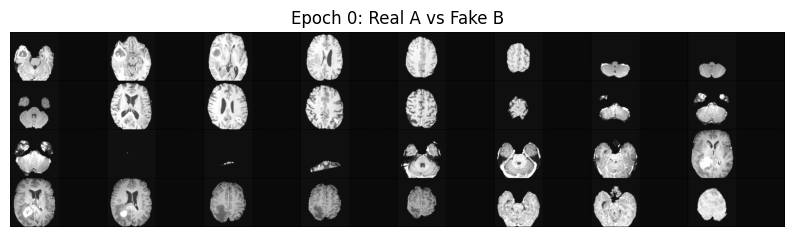

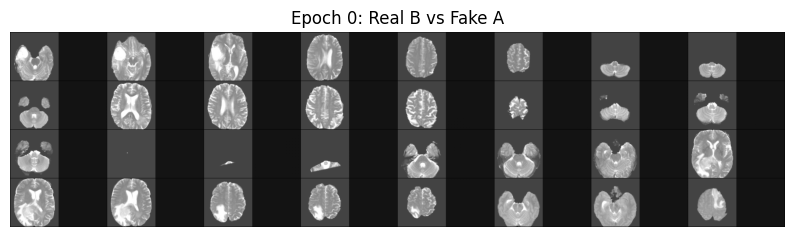

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

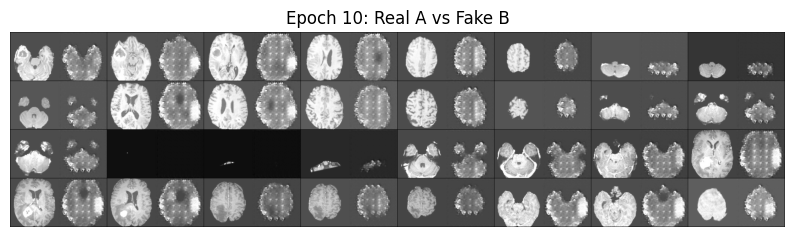

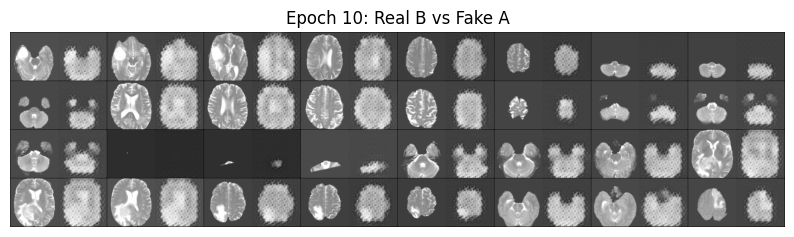

Validation: |          | 0/? [00:00<?, ?it/s]

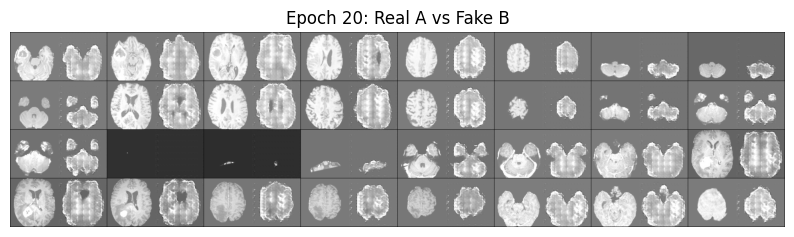

Validation: |          | 0/? [00:00<?, ?it/s]

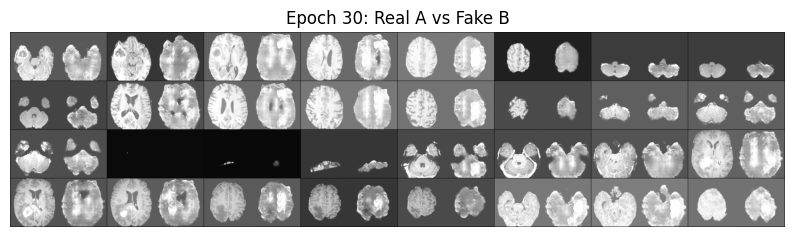

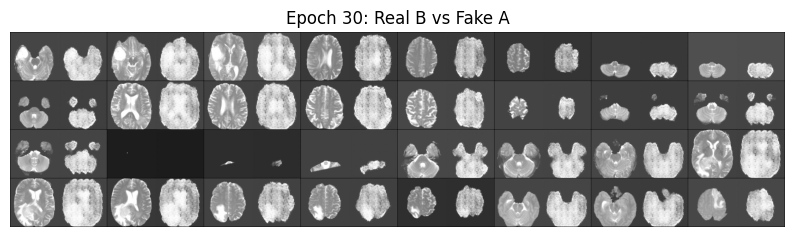

Validation: |          | 0/? [00:00<?, ?it/s]

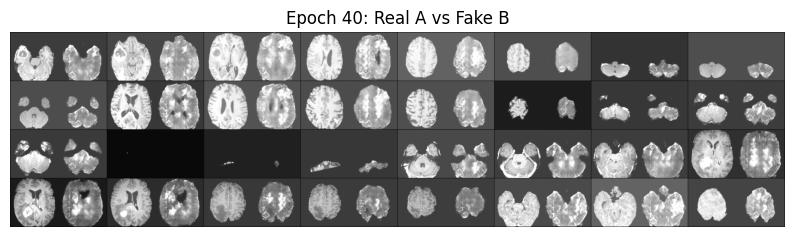

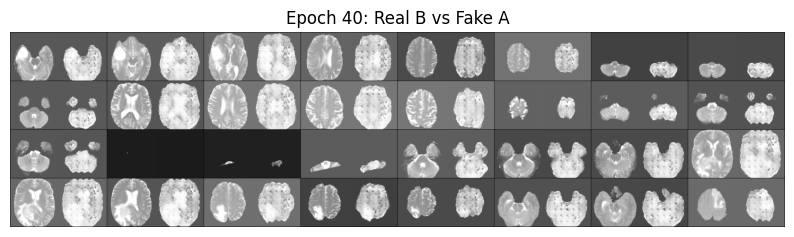

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
trainer.fit(model, datamodule=data_module)

Saving parameters for the finetuning procedure.

In [ ]:
trainer.save_checkpoint("training_checkpoint.ckpt")

# 4. Finetuning

Define the dataset and the PyTorchLightning Datamodule to load and handle the finetuning data.

In [ ]:
class FineTuneDataset(Dataset):
  def __init__(self, t1ce_dir, mask_dir, transform=None):
    self.t1ce_dir = t1ce_dir
    self.mask_dir = mask_dir
    self.transform = transform

    self.t1ce_images = sorted(os.listdir(t1ce_dir))
    self.mask_images = sorted(os.listdir(mask_dir))

  def __len__(self):
    return len(self.t1ce_images)

  def __getitem__(self, idx):
    t1ce_path = os.path.join(self.t1ce_dir, self.t1ce_images[idx])
    mask_path = os.path.join(self.mask_dir, self.mask_images[idx])

    t1ce_image = Image.open(t1ce_path).convert('L')
    mask_image = Image.open(mask_path).convert('L')

    if self.transform:
      t1ce_image = self.transform(t1ce_image)
      mask_image = self.transform(mask_image)

    return t1ce_image, mask_image

In [ ]:
class FineTuneDataModule(pl.LightningDataModule):
  def __init__(self, dataset_zip_path, batch_size=32, image_size=256):
    super().__init__()
    self.batch_size = batch_size
    self.image_size = image_size
    self.transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])

    self.extract_dataset(dataset_zip_path)

  def extract_dataset(self, zip_path):
    from zipfile import ZipFile
    with ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall('NNDataset')

    self.t1ce_dir = os.path.join('NNDataset/Dataset', 't1ce_jpg')
    self.mask_dir = os.path.join('NNDataset/Dataset', 'mask_jpg')

  def setup(self, stage=None):
    self.finetune_dataset = FineTuneDataset(
        t1ce_dir=self.t1ce_dir,
        mask_dir=self.mask_dir,
        transform=self.transform
    )

  def train_dataloader(self):
    return DataLoader(self.finetune_dataset, batch_size=self.batch_size,
                      shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.finetune_dataset, batch_size=self.batch_size,
                      shuffle=False)

  def predict_dataloader(self):
    return DataLoader(self.finetune_dataset, batch_size=self.batch_size,
                      shuffle=False)

The finetuning process uses a loss made of three components again:
* MSE Loss: Measures the mean squared error between the predicted and ground truth masks;
* Focal Loss: Helps in dealing with class imbalance by focusing more on hard-to-classify examples;
* Dice Loss: Measures the overlap between the predicted and ground truth masks, common in segmentation tasks.

In [ ]:
class FocalLoss(nn.Module):
  def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
    super(FocalLoss, self).__init__()
    self.alpha = alpha
    self.gamma = gamma
    self.reduction = reduction

  def forward(self, inputs, targets):
    BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets,
                                                              reduction='none')
    pt = torch.exp(-BCE_loss)
    pt = torch.clamp(pt, 1e-6, 1-1e-6)  # Clamp to avoid too large values

    F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

    if self.reduction == 'mean':
      return torch.mean(F_loss)
    elif self.reduction == 'sum':
      return torch.sum(F_loss)
    else:
      return F_loss

In [ ]:
class DiceLoss(nn.Module):
  def __init__(self, smooth=1e-6):
    super(DiceLoss, self).__init__()
    self.smooth = smooth

  def forward(self, inputs, targets):
    inputs = torch.sigmoid(inputs)
    intersection = (inputs * targets).sum(dim=[1, 2, 3])
    union = inputs.sum(dim=[1, 2, 3]) + targets.sum(dim=[1, 2, 3])
    dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
    return 1 - dice_score.mean()

PyTorch Lightning LightningModule to define training and validation procedures for the finetuning of the model.

In [ ]:
class FineTuneModel(pl.LightningModule):
  def __init__(self, lambda_c=0.1, lambda_t=10, lambda_r=1):
    super().__init__()
    self.lambda_c = lambda_c
    self.lambda_t = lambda_t
    self.lambda_r = lambda_r

    # Use the full architecture for segmentation
    self.gen = MultiConDoS.load_from_checkpoint("training_checkpoint.ckpt")

    # Define loss functions
    self.criterion_MSE = nn.MSELoss()
    self.criterion_Focal = FocalLoss()
    self.criterion_Dice = DiceLoss()

  def forward(self, x):
    return self.gen(x)

  def training_step(self, batch, batch_idx):
    t1ce_image, mask_image = batch

    # Forward pass through the generator to get the segmentation mask
    pred_mask, _ = self.gen(t1ce_image)

    # Compute the losses
    mse_loss = self.criterion_MSE(pred_mask, mask_image)
    focal_loss = self.criterion_Focal(pred_mask, mask_image)
    dice_loss = self.criterion_Dice(pred_mask, mask_image)

    # Total loss
    loss = mse_loss + focal_loss + dice_loss
    self.log('finetune_loss', loss, prog_bar=True)

    return loss

  def validation_step(self, batch, batch_idx):
    t1ce_image, mask_image = batch

    # Forward pass through the generator to get the predicted mask
    pred_mask, _ = self.gen(t1ce_image)

    # Compute the losses
    mse_loss = self.criterion_MSE(pred_mask, mask_image)
    focal_loss = self.criterion_Focal(pred_mask, mask_image)
    dice_loss = self.criterion_Dice(pred_mask, mask_image)

    # Log the losses
    self.log('val_mse_loss', mse_loss, prog_bar=True)
    self.log('val_focal_loss', focal_loss, prog_bar=True)
    self.log('val_dice_loss', dice_loss, prog_bar=True)

    # Every 10 epochs, display the masks
    condition = (self.current_epoch % 10 == 9)
    if condition and batch_idx == 0:
      if self.current_epoch % 10 == 0:
        epoch = self.current_epoch
      else:
        epoch = self.current_epoch + 1
      title=f"Epoch {epoch}: T1CE vs Predicted vs Ground Truth Mask"
      self.display_images(t1ce_image, pred_mask, mask_image, title=title)

  def predict_step(self, batch, batch_idx):
    t1ce_image, _ = batch

    # Forward pass to get predicted mask
    pred_mask, _ = self.gen(t1ce_image)

    # Save predictions to files
    self.save_predictions(pred_mask, batch_idx)

    return pred_mask

  def save_predictions(self, pred_mask, batch_idx):
    # Denormalize and save each mask in the batch
    pred_mask = pred_mask.cpu().detach()

    # Avoid division by zero
    pred_mask = (pred_mask - pred_mask.min()) / (pred_mask.max() -
                                                 pred_mask.min() + 1e-8)

    # Save each mask as a separate file
    for i in range(pred_mask.size(0)):  # Iterate over batch size
      mask = pred_mask[i]
      mask_image = TF.to_pil_image(mask)
      mask_filename = os.path.join("generated_masks", f'mask_{batch_idx * pred_mask.size(0) + i}.png')
      mask_image.save(mask_filename)

  def display_images(self, t1ce, pred_mask, true_mask, title=""):
    t1ce = t1ce.cpu().detach()
    pred_mask = pred_mask.cpu().detach()
    true_mask = true_mask.cpu().detach()

    # Combine images for display
    comparison = torch.cat([t1ce, pred_mask, true_mask], dim=3)  # Side-by-side comparison
    grid = vutils.make_grid(comparison, normalize=True, scale_each=True)

    # Convert to numpy for matplotlib
    np_grid = grid.numpy().transpose((1, 2, 0))

    # Plot using matplotlib
    plt.figure(figsize=(20, 10))
    plt.imshow(np_grid)
    plt.title(title)
    plt.axis('off')
    plt.show()

  def on_train_epoch_end(self):
    # Print val state of epoch
    logged_values = self.trainer.progress_bar_metrics

    if log_wandb:
      wandb.log(logged_values)

  def configure_optimizers(self):
    lr = 0.0002
    opt = torch.optim.Adam(self.gen.parameters(), lr=lr)
    return opt

# 5. Model Finetuning

Dataset, model and trainer instantiation.

In [ ]:
# Fine-tuning setup
finetune_data_module = FineTuneDataModule(dataset_zip_path='NNDataset.zip')

In [ ]:
fine_tune_model = FineTuneModel()

In [ ]:
trainer = pl.Trainer(max_epochs=100, accelerator="cuda")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type        | Params | Mode 
--------------------------------------------------------
0 | gen             | MultiConDoS | 25.0 M | train
1 | criterion_MSE   | MSELoss     | 0      | train
2 | criterion_Focal | FocalLoss   | 0      | train
3 | criterion_Dice  | DiceLoss    | 0      | train
--------------------------------------------------------
25.0 M    Trainable params
0         Non-trainable params
25.0 M    Total params
100.001   Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

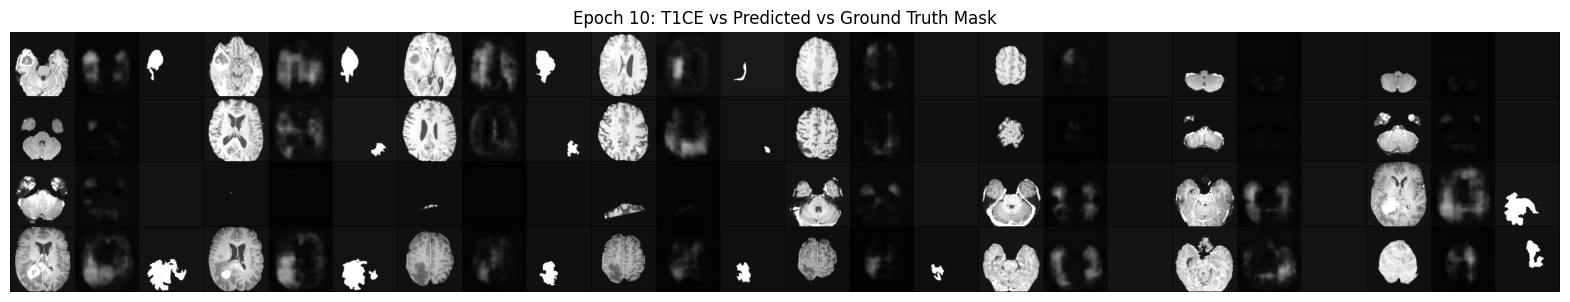

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

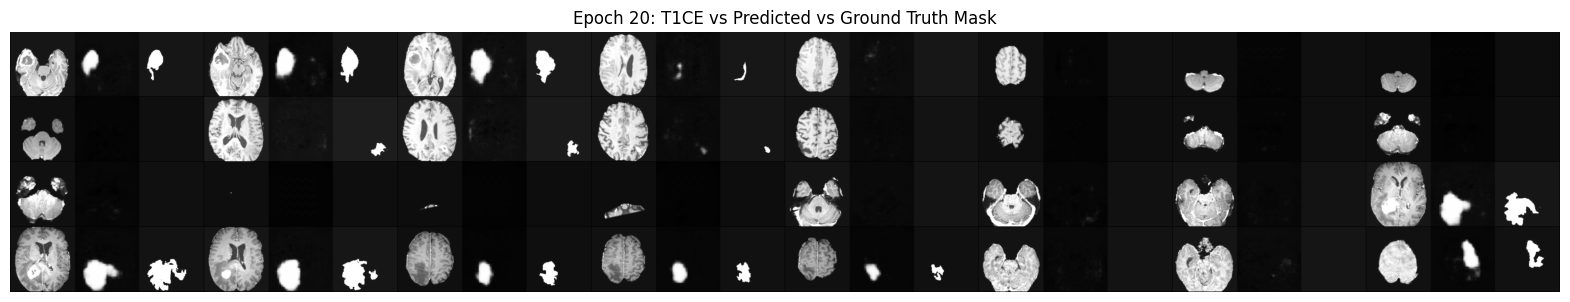

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

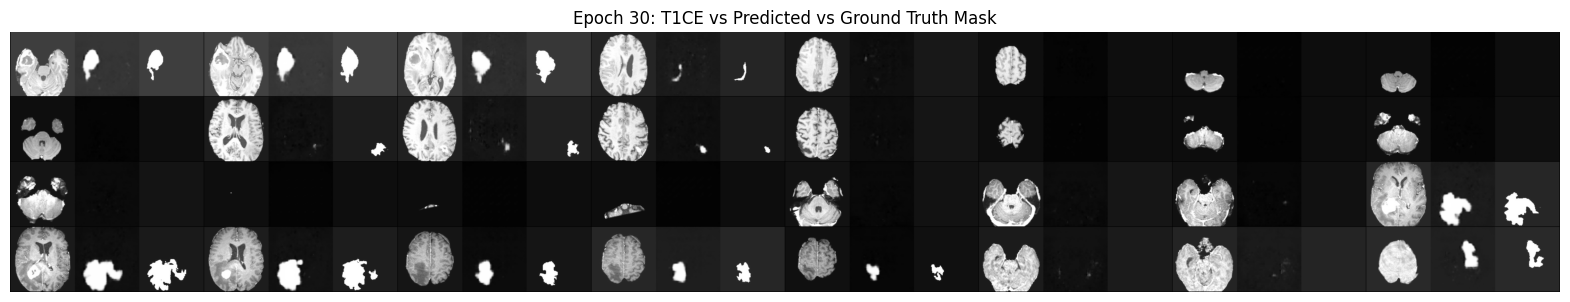

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

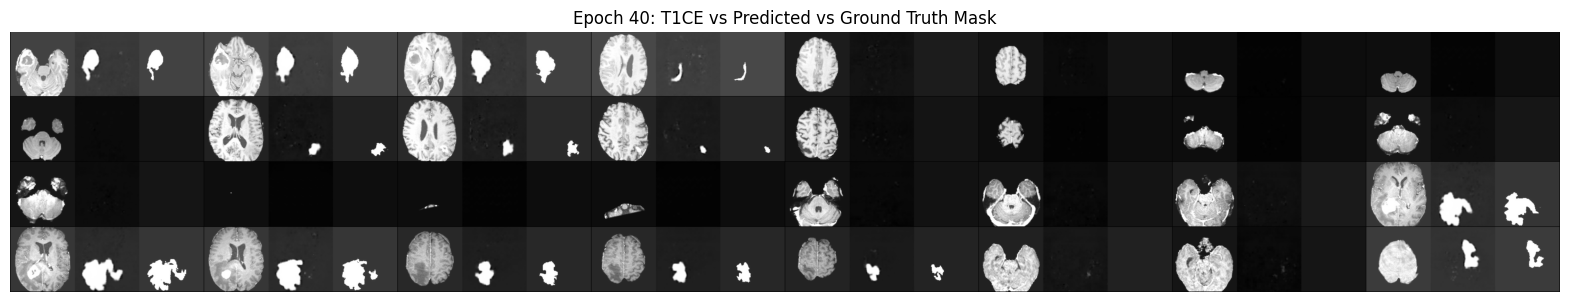

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

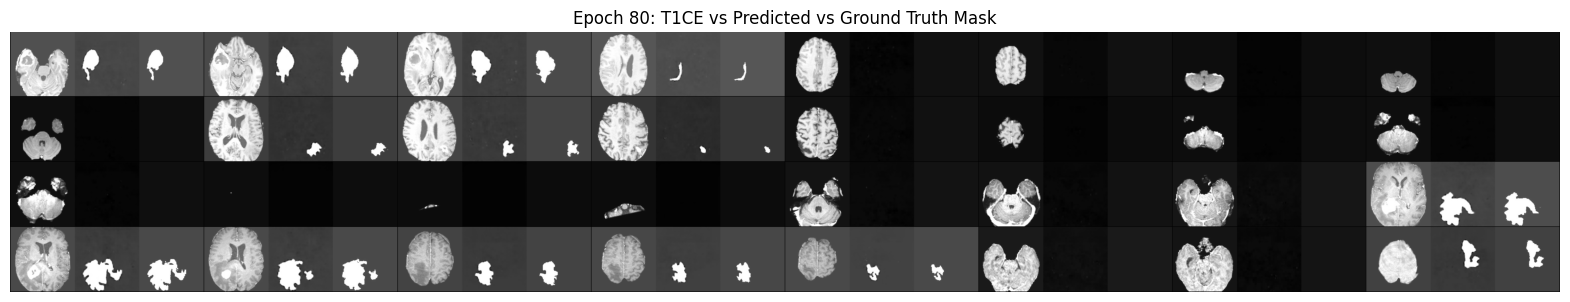

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

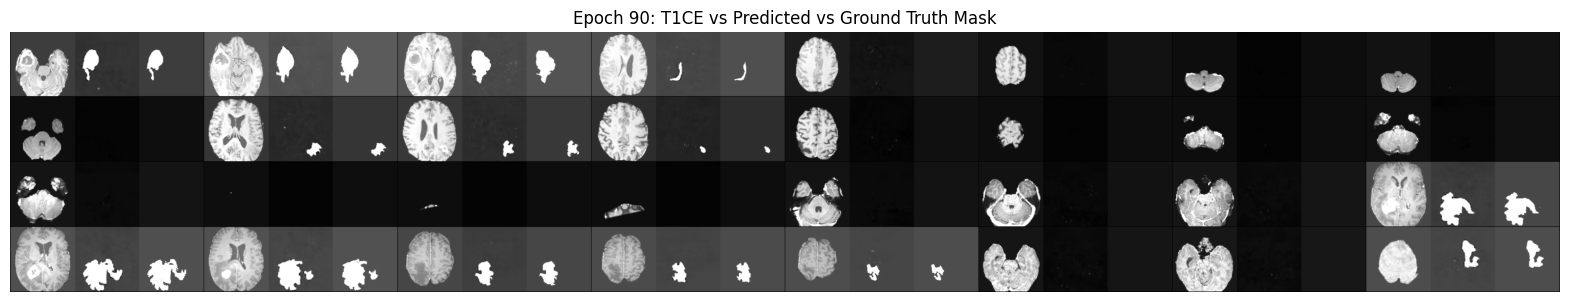

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

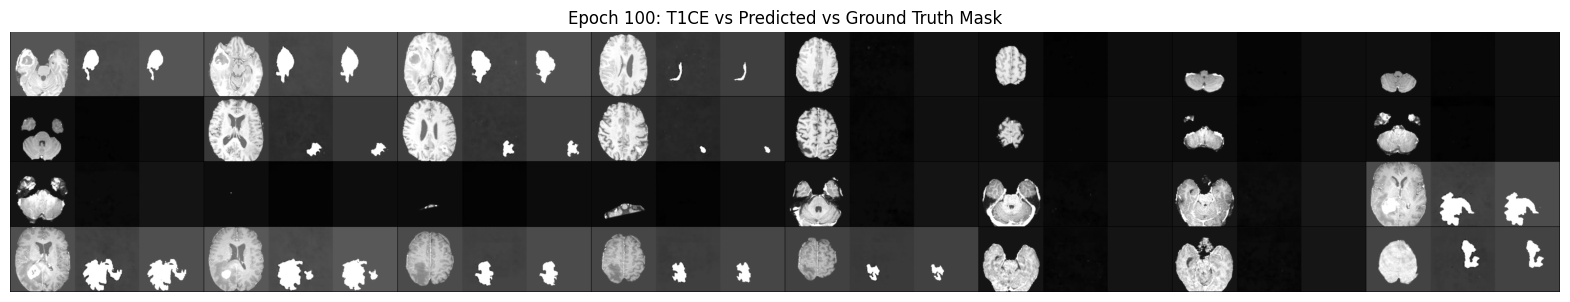

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
trainer.fit(fine_tune_model, finetune_data_module)

Saving the predicted masks.

In [ ]:
os.makedirs("generated_masks", exist_ok=True)
predictions = trainer.predict(fine_tune_model, finetune_data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Saving model parameters.

In [ ]:
trainer.save_checkpoint("finetuning_checkpoint.ckpt")

In [ ]:
!zip -q training_checkpoint.ckpt.zip training_checkpoint.ckpt
!zip -q finetuning_checkpoint.ckpt.zip finetuning_checkpoint.ckpt
!zip -q -r generated_masks.zip generated_masks

In [7]:
if log_wandb:
  wandb.finish()

# 6. Results

The dataset used in this work, the weights of the trained and the finetuned model, as well as the masks generated after the finetuning process can be found in [this](https://drive.google.com/drive/folders/1IkqiZmgY8VJyWm1ZDaK6d5-7kIijSxFa?usp=sharing) Google Drive folder.

Here are the evolution of the different losses during both training and finetuning:

###Training Losses:

![](https://drive.google.com/uc?export=view&id=1Wwi8cAlQSyI0mNg9t1LbDHrVfdze9qAC)

![](https://drive.google.com/uc?export=view&id=12g1zjyqBFOSP7uJrYrBdqcjRTZsVWMPV)

![](https://drive.google.com/uc?export=view&id=1luA-iOYR1DwQ48rmXQh1kv4kQu-PVStv)


### Finetuning Losses:
![](https://drive.google.com/uc?export=view&id=10-gS-bLNJjm76DNJjpz5IOyHn2bP_xq5)

![](https://drive.google.com/uc?export=view&id=19OLTxxCKzi6dJmF2N6KAJVRMqh228HJq)

![](https://drive.google.com/uc?export=view&id=1LpMyYycKcox5POFiMiFh13hGQHpeWKhw)

![](https://drive.google.com/uc?export=view&id=1EnvsapIX44GS6B2CZwpfONGldOfPS1wc)

 ### These are some of the masks generated by the model:

![](https://drive.google.com/uc?export=view&id=1AYWUh3AqV0mFWxlgegZor0kx2RAzK7Ma) ![](https://drive.google.com/uc?export=view&id=1Li1MZqBjMWH_xtdP3jQMdgaq1iH_w-ef) ![](https://drive.google.com/uc?export=view&id=1R6X2-1J8MJ0jyOZj2KARLJ9h7qiyWyOd) ![](https://drive.google.com/uc?export=view&id=1jMw-8hnBpCCggjozwjCbyZlq8nzDSdt0) ![](https://drive.google.com/uc?export=view&id=1lTkoqPO90qCcm_j3bcxysMiAVICoF7Xi)